In [1]:
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import wandb

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from anime_face_generator.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

%load_ext autoreload
%autoreload 2

2025-08-02 17:58:37.179 | INFO     | anime_face_generator.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/anime_face_generator


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data augmentation

In [4]:
img_size = (64, 64)
batch_nbr = 16
channels = 3

img_dim=img_size[0] * img_size[1] * channels

In [5]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=img_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # torchvision.transforms.Lambda(lambda x: x.view(-1))  #flattening
])

dataset = torchvision.datasets.ImageFolder(root=PROCESSED_DATA_DIR, transform=transformers, target_transform=None)

In [6]:
rand_gen = torch.Generator().manual_seed(142)

## Architecture

----------------- EPOCH 0------------------
loss: 1.619602  [   16/80503]
>>>>>>>>timestep in first x in the batch:  tensor(62, device='cuda:0')


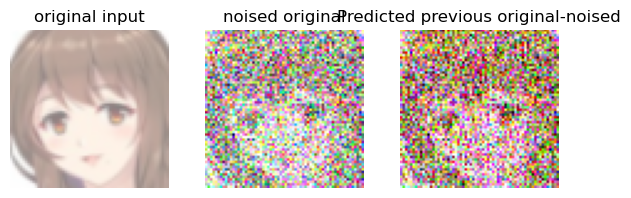

loss: 1.619602  [   16/80503]


In [ ]:
T = 100  # total diffusion steps

# Linear noise schedule
beta = torch.linspace(1e-4, 0.02, T).to(device)         # β_t ∈ (0.0001, 0.02)
alpha = 1. - beta                           # α_t = 1 - β_t
alpha_bar = torch.cumprod(alpha, dim=0)     # \bar{α}_t = product of α_1 to α_t


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(
            torch.arange(half_dim, device=device) * -(np.log(10000) / (half_dim - 1))
        )
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb  # shape: (B, dim)
    
def conv_block(in_channels=channels,out_channels=channels, kernel_size=3,
                stride=1, padding=1, pool_kernel_size=1,
                pool_stride=2, dropout_prob=0.1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout_prob),
#         nn.MaxPool2d(pool_kernel_size, pool_stride)
    )

class DenoiseUNet(nn.Module):
    def __init__(self, time_emb_dim=128, fc_dropout_prob=0.3, dropout_prob=0.2):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        self.conv1 = nn.Conv2d(channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, channels * 5, 3, padding=1)
        self.conv_block = conv_block(channels * 5, channels)
        self.fc_time = nn.Linear(time_emb_dim, 32)
        
        self.fc_layers = nn.Sequential(
           nn.Dropout(fc_dropout_prob),
           nn.LazyLinear(512),
           nn.ReLU(inplace=True),
           nn.Linear(512, channels)
        )

    def forward(self, x, t):
        time_emb = self.time_mlp(t.to(device)).to(device)               # (B, D)
        time_emb = self.fc_time(time_emb)         # (B, 32)
        time_emb = time_emb[:, :, None, None]     # (B, 32, 1, 1)

        x = self.conv1(x)
        x = x + time_emb
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.conv_block(x)
        return x

def get_loss(model, x0, t=None):
    B = x0.shape[0]
    if t is None:
        t = torch.randint(0, T, (B,), device=x0.device).long()
    noise = torch.randn_like(x0).to(device)
    x_t = q_sample(x0, t, noise).to(device)
    pred_noise = model(x_t.to(device), t.to(device)).to(device)
    return nn.MSELoss()(pred_noise, noise), pred_noise, x_t


def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0).to(device)
    
    sqrt_alpha_bar = alpha_bar[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
    
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

model = DenoiseUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dataloader = tdata.DataLoader(
    dataset=dataset,
    batch_size=batch_nbr,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# Training Loop
num_epochs = 20
size = len(dataloader.dataset)
model.train()
import torchvision.transforms.functional as TF

for epoch in range(num_epochs):
    print("----------------- EPOCH " + str(epoch) + "------------------")
    for batch, (x0_batch, _) in enumerate(dataloader):  # assume x0_batch ∈ [B, 1, 28, 28]
        x0_batch = x0_batch.to(device)
        t = torch.randint(0, T, (x0_batch.shape[0],), device=x0_batch.device).long()
        loss, pred_noise, x_t = get_loss(model, x0_batch, t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if batch % (16 * 100) == 0:
            loss_val, current = loss.item(), batch * batch_nbr + len(x0_batch)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")
            print(">>>>>>>>timestep in first x in the batch: ", t[0])
    
            # Visualize one sample
            idx = 0  # you can change which sample in the batch to preview
            img = x0_batch[idx].detach().cpu()
            pred = pred_noise[idx].detach().cpu()
            xt = x_t[idx].detach().cpu()
            t_0 = t[idx].detach().cpu()
    
            # Option 1: show predicted noise
            plt.figure(figsize=(6, 2))
            plt.subplot(1, 3, 1)
            plt.imshow(np.clip((img.permute(1, 2, 0) + 1) / 2, 0, 1))
            plt.title("original input")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(np.clip((xt.permute(1, 2, 0) + 1) / 2, 0, 1))
            plt.title("noised original")
            plt.axis("off")

            beta_t = beta[t_0].view(-1, 1, 1, 1)
            sqrt_alpha_t = alpha[t_0].sqrt().view(-1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = (1 - alpha_bar[t_0]).sqrt().view(-1, 1, 1, 1)

            # Predict noise
            eps_theta = pred

            # Compute predicted x_0
            pred_x0 = (xt - sqrt_one_minus_alpha_bar_t.detach().cpu() * pred) / sqrt_alpha_t.detach().cpu()
#             print(pred_x0.shape)
#             print(xt.shape)
            plt.subplot(1, 3, 3)
            plt.imshow(np.clip(((pred_x0[0].permute(1, 2, 0) + 1) / 2), 0, 1))
            
            plt.title("Predicted previous original-noised")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
#             print((xt.permute(1, 2, 0) + 1) / 2 - (pred.permute(1, 2, 0) + 1) / 2)
            loss, current = loss.item(), batch * batch_nbr + len(x0_batch)
#             wandb.log({"step":  f"{current:>5d}/{size:>5d}", "train_loss": loss})
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
#             plt.show(x0_batch - pred_noise[0])
        
print("finished")
        

## Simpling from the learned distribution

In [ ]:
@torch.no_grad()
def p_sample(model, x_t, t):
    beta_t = beta[t].view(-1, 1, 1, 1)
    sqrt_alpha_t = alpha[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)

    # Predict noise
    eps_theta = model(x_t, t)

    # Compute predicted x_0
    pred_x0 = (x_t - sqrt_one_minus_alpha_bar_t * eps_theta) / sqrt_alpha_t

    # Compute mean (μ_θ)
    mu = (1 / sqrt_alpha_t) * (x_t - beta_t / sqrt_one_minus_alpha_bar_t * eps_theta)

    # Sample noise (except for last step)
    if t[0] > 0:
        noise = torch.randn_like(x_t)
    else:
        noise = torch.zeros_like(x_t)

    x_prev = mu + beta_t.sqrt() * noise
    return x_prev.clamp(-1, 1)


In [ ]:
@torch.no_grad()
def generate(model, shape=(1, 1, 28, 28)):
    x = torch.randn(shape).to(device)
    for t_step in reversed(range(T)):
        t = torch.full((shape[0],), t_step, dtype=torch.long).to(device)
        x = p_sample(model, x, t)
    return x


In [ ]:

@torch.no_grad()
def generate_samples(model, num_samples=48, image_size=img_size):
    model.eval()
    samples = generate(model, shape=(num_samples, 3, *image_size))
    return samples

def show_images_grid_rgb(samples, nrow=8, ncol=6):
    fig, axes = plt.subplots(ncol, nrow, figsize=(nrow, ncol))
    samples = (samples + 1) / 2         # Rescale from [-1, 1] to [0, 1]
    samples = samples.clamp(0, 1).cpu() # Ensure valid pixel range
    samples = samples.permute(0, 2, 3, 1)  # Convert to (N, H, W, C) for plotting

    idx = 0
    for row in range(ncol):
        for col in range(nrow):
            axes[row, col].imshow(samples[idx])
            axes[row, col].axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()

# Example usage:
samples = generate_samples(model, num_samples=48, image_size=(32, 32))  # adapt shape to your dataset
show_images_grid_rgb(samples, nrow=8, ncol=6)


# Generate and plot
samples = generate_samples(model, num_samples=48)
show_images_grid(samples, nrow=8, ncol=6)


In [ ]:
import time
correct = "none"
model_name = f"{correct}--" + time.strftime("%Y-%m-%d_%H-%M-%S") + "_VDM_model.pth"
torch.save(model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

 ### Saving the notebook.

In [ ]:
# %%javascript
# IPython.notebook.save_notebook()
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')